In [1]:
import numpy as np 
import pandas as pd 
import os
import re
import statsmodels.api as sm
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import matplotlib
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import glob
currdir = os.getcwd()
parent = os.path.dirname(currdir)
gparent = os.path.dirname(parent)
import seaborn as sns
from scipy import stats


In [2]:
def custom_sort(item):
    if item.endswith('basal'):
        return 0  
    else:
        return int(item.split('DIV')[-1])
def ensure_dirs_exists(path):
    directory = os.path.dirname(path)  # Get the directory part of the file path
    if not os.path.exists(directory):
        os.makedirs(directory)
    return

In [3]:
## read in data, div19_26uMbicucilin, 19_basal
lines_to_skip = 10 # adjust 

# count the number of header lines
firstTableHeading = "Mean Firing Rate (hz)"

FOLDER_PATH = f"{parent}/data/DATA for PCA for Pooja/" #
folder_dict = {}

## WALK Through folder of interest
for dirpath, dirnames, filenames in os.walk(FOLDER_PATH):
    if dirpath != FOLDER_PATH:
        folder_dict[dirpath.split("/")[-1]] = dirpath


folders = {key: folder_dict[key] for key in sorted(folder_dict.keys(), key=custom_sort)}

folders

{'DIV5': '/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/DATA for PCA for Pooja/DIV5',
 'DIV8': '/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/DATA for PCA for Pooja/DIV8',
 'DIV10': '/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/DATA for PCA for Pooja/DIV10',
 'DIV11': '/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/DATA for PCA for Pooja/DIV11',
 'DIV12': '/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/DATA for PCA for Pooja/DIV12',
 'DIV13': '/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/DATA for PCA for Pooja/DIV13',
 'DIV14': '/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/DATA for PCA for Pooja/DIV14',
 'DIV15': '/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/DATA for PCA for Pooja/DIV15',
 'DIV16': '/home/poojaparame

In [4]:
def read_csvs_to_dict(folder, lines_to_skip=10):
    files = glob.glob(os.path.join(folder, "*.csv"))
    data_dict = {}
    for file in files:
        plate_num = re.search(r'plate\s?(\d+)', file, re.IGNORECASE)
        if plate_num:
            plate_key = f"plate_{plate_num.group(1)}"
            df = pd.read_csv(file, skiprows = lines_to_skip)
            df = df.drop(columns=['Unnamed: 9'])
            df['Subject'] = plate_key
            data_dict[plate_key] = df
    return data_dict
get_plates = {}

for day, folder in folders.items():
    get_plates[day] = read_csvs_to_dict(folder)
for day, files_dict in get_plates.items():
    print(files_dict.keys())

dict_keys(['plate_1', 'plate_3', 'plate_2'])
dict_keys(['plate_1', 'plate_2', 'plate_3'])
dict_keys(['plate_1', 'plate_2', 'plate_3'])
dict_keys(['plate_1', 'plate_2', 'plate_3'])
dict_keys(['plate_3', 'plate_1', 'plate_2'])
dict_keys(['plate_2', 'plate_3', 'plate_1'])
dict_keys(['plate_1', 'plate_2', 'plate_3'])
dict_keys(['plate_1', 'plate_3', 'plate_2'])
dict_keys(['plate_3', 'plate_1', 'plate_2'])
dict_keys(['plate_2', 'plate_3', 'plate_1'])
dict_keys(['plate_3', 'plate_2', 'plate_1'])
dict_keys(['plate_2', 'plate_3', 'plate_1'])


In [5]:
def concat_plates(plates_dict, firstHeading):
    experiment = {}
    testparams_concat = {}
    for plate, df in plates_dict.items():
        maxrows = df.shape[0]
        vals_between_tables = 16
        titles = [heading_ind for heading_ind in range(14, maxrows+16, 16)]
        titles.insert(0,0)
        # # Empty dictionary to store dataframes
        # Loop through start indices
        for ind in range(len(titles) -1):
            if ind == 0:
                ## Handle mean firing rate
                key = firstHeading
                table = df.iloc[titles[ind] : titles[ind +1], :]
                # table = rename_row_names(table)
            elif ind != 0:
                table = df.iloc[titles[ind] : titles[ind +1], :]
                key = table.iloc[0][0] # just get name
                table = df.iloc[titles[ind] +2: titles[ind +1], :]

            table.set_index('Unnamed: 0', inplace=True)
            if key not in experiment:
                experiment[key] = []
            experiment[key].append(table)
    
    for testparam, df_list in experiment.items():
        concated_table = pd.concat(df_list, ignore_index=False)
        testparams_concat[testparam] = concated_table
    
    testparams_concat = {key.strip(): value.drop(columns=['Subject']) for key, value in testparams_concat.items()}
    return testparams_concat

DIVS = {}
for day, plates in get_plates.items():
    DIVS[day] = concat_plates(plates, firstTableHeading)

DIVS

{'DIV5': {'Mean Firing Rate (hz)':               GPR37L 1  GPR37L 2  LGI2 A12   SLITRK5   THSD7 1   THSD7 2  \
  Unnamed: 0                                                                 
  B Mean        0.375782  0.266177  0.330918  0.350796  0.286454  0.311944   
  B SEM         0.046294  0.037405  0.044896  0.057151  0.046487  0.041566   
  B Replicates  0.312969  0.117389  0.272936  0.304629  0.472686  0.454962   
  NaN           0.330067  0.350500  0.375938  0.417848  0.232068  0.481860   
  NaN           0.290242  0.242911  0.421810  0.129900  0.085488  0.298791   
  NaN           0.525438  0.189950  0.231860  0.803169  0.160133  0.152210   
  NaN           0.329024  0.283153  0.513761  0.485196  0.332360  0.301293   
  NaN           0.242077  0.338407  0.370309  0.483736  0.283987  0.194954   
  NaN           0.786072  0.568599  0.282110  0.222477  0.077773  0.255213   
  NaN           0.441410  0.246247  0.133445  0.445580  0.209341  0.102168   
  NaN           0.153461  0.386

In [6]:
def remove_mean_SEM(test_dict, day):
    for key, value in test_dict.items():
        to_drop = [index for index in ['B Mean', 'B SEM', 'B Std'] if index.casefold() in value.index.str.casefold()]
        if to_drop:
            test_dict[key] = value.drop(index=to_drop)
        test_dict[key].loc[:, 'DIV']=day
    return test_dict
for day, parameter_dict in DIVS.items():
    DIVS[day] = remove_mean_SEM(parameter_dict, day)

DIVS['DIV10']

{'Mean Firing Rate (hz)':               GPR37L 1  GPR37L 2  LGI2 A12   SLITRK5   THSD7 1   THSD7 2  \
 Unnamed: 0                                                                 
 B Replicates  4.278009  3.288838  3.154935  4.244690  4.164723  3.146606   
 NaN           4.022491  3.225739  4.771137  5.350062  4.450646  3.275927   
 NaN           5.975010  2.851312  3.890462  2.645356  4.113911  3.023324   
 NaN           3.681799  4.023324  6.729488  3.817368  3.042691  3.286547   
 NaN           5.312162  2.901708  3.648688  5.216368  3.027697  2.407955   
 NaN           4.671595  2.634527  3.131404  4.765306  2.819867  2.383174   
 NaN           2.971678  3.503748  3.612661  3.557268  2.019367  5.258642   
 NaN           4.507705  3.949396  3.503124  4.172636  3.278217  2.837776   
 NaN           4.524365  3.483340  2.213036  4.124323  2.472720  3.035402   
 NaN           3.770096  3.380050  3.004373  4.857351  4.343190  4.918159   
 NaN           4.608288  3.627655  4.757809  3.0918

In [7]:
def rename_row_names(experiment_df):
    experiment_df = experiment_df.reset_index()
    experiment_df = experiment_df.drop(columns="Unnamed: 0", errors="ignore")

    experiment_df.index = [f"Replicate{i+1}" for i in range(len(experiment_df))]
    return experiment_df
for day, test_dict in DIVS.items():
    for test_name, df in test_dict.items():
        test_dict[test_name] = rename_row_names(df)
    DIVS[day] = test_dict
DIVS

{'DIV5': {'Mean Firing Rate (hz)':              GPR37L 1  GPR37L 2  LGI2 A12   SLITRK5   THSD7 1   THSD7 2  \
  Replicate1   0.312969  0.117389  0.272936  0.304629  0.472686  0.454962   
  Replicate2   0.330067  0.350500  0.375938  0.417848  0.232068  0.481860   
  Replicate3   0.290242  0.242911  0.421810  0.129900  0.085488  0.298791   
  Replicate4   0.525438  0.189950  0.231860  0.803169  0.160133  0.152210   
  Replicate5   0.329024  0.283153  0.513761  0.485196  0.332360  0.301293   
  Replicate6   0.242077  0.338407  0.370309  0.483736  0.283987  0.194954   
  Replicate7   0.786072  0.568599  0.282110  0.222477  0.077773  0.255213   
  Replicate8   0.441410  0.246247  0.133445  0.445580  0.209341  0.102168   
  Replicate9   0.153461  0.386155  0.259800  0.381985  0.335696  0.199333   
  Replicate10  0.420142  0.141159  0.307756  0.129691  0.621351  0.566097   
  Replicate11  0.325688  0.188907  0.675354  0.292535  0.204545  0.303378   
  Replicate12  0.352794  0.140742  0.125938

In [8]:
def impute_nans(table):
    days = table['DIV']
    table = table.drop(columns=['DIV'])
    original_index = table.index
    imputer = IterativeImputer(max_iter=100, random_state=0)
    imputed_data = imputer.fit_transform(table)
    # Convert the imputed data back to a DataFrame
    imputed_df = pd.DataFrame(imputed_data, columns=table.columns, index=original_index)
    imputed_df['DIV'] = days
    return imputed_df

for day, tstdict in DIVS.items():
    for test, table in tstdict.items():
        tstdict[test] = impute_nans(table)
    DIVS[day] = tstdict

# # if nans in all columns, skip. need to remove chemtype and subject bc these will never have nans
# DIVSimp = {test_param: impute_nans(test_param, table) for test_param, table in DIVS.items() \
#     if not table.loc[:, ~(table.columns.isin(['Chemical_Type']))].isna().all().all()
# } 


**Lambdas for each feature are saved in `BC_LAMBDAS`**

With the following hierarchy:
`BC_LAMBDA` (dict)
|-> Test (meanfiringrate)
    all divs concatenated
    
    |-> lambda value

In [9]:
# ## box cox on all. looks good , more normally distributed on the histogram
# def box_cox(test_data):
#     print(test_data)
#     dr = test_data.replace(0, 0.0001)
#     dr = dr.drop(columns=['DIV'])
#     original_shape, cols = dr.shape, dr.columns# Save the original shape

#     dr = (dr.to_numpy().flatten())
# #     print(negative_values)
#     bc_data, fit_lambda = stats.boxcox(dr)    
#     bcdatar = np.reshape(bc_data, original_shape)
#     bcdf = pd.DataFrame(bcdatar, columns=cols)
#     bcdf['DIV'] = test_data['DIV'].values  # Reattach 'Chemical_Type'
#     return fit_lambda, bcdf

# BC_DIVS = {day: {} for day in DIVS.keys()}
# BC_LAMBDAS = {day: {} for day in BC_DIVS.keys()}
# for day, tstdict in DIVS.items():
#     for test, data in tstdict.items():
#         lambd , df= box_cox(data)
#         BC_LAMBDAS[day][test] = lambd
#         BC_DIVS[day] [test] = df
# BC_DIVS['DIV5'].keys()

In [10]:
## now only take unt2
import copy
def keep_genes(DIVdf, gene):
    k = DIVdf[[gene]]
    return k.copy()

DIVSU =  {day: {} for day in DIVS.keys()}


for day, dct in DIVS.items():
    new_dct = copy.deepcopy(dct)  
    for (test), df in new_dct.items():
        new_dct[(test)]= keep_genes(df, 'unt2')
    DIVSU[day] = new_dct
DIVSU.keys()

dict_keys(['DIV5', 'DIV8', 'DIV10', 'DIV11', 'DIV12', 'DIV13', 'DIV14', 'DIV15', 'DIV16', 'DIV17', 'DIV18', 'DIV19'])

,GPR37L 1,GPR37L 2,LGI2 A12,SLITRK5,THSD7 1,THSD7 2,unt1,unt2,DIV
Replicate1,1.827421,3.278172,5.325334,3.735184,0.840568,3.100167,3.665484,2.135017,DIV19
Replicate2,0.901503,6.809265,0.281511,1.074499,4.000626,3.151920,3.726210,1.878548,DIV19
Replicate3,7.349958,2.711603,1.391903,2.271077,2.575334,2.032137,7.272120,2.567195,DIV19
Replicate4,1.503130,2.224958,1.152129,4.904215,0.460559,1.641068,5.093907,7.638564,DIV19
Replicate5,2.211811,3.282137,1.718907,4.165275,3.251043,0.664441,4.756469,1.001461,DIV19
Replicate6,0.859349,1.075960,0.144616,2.927588,2.784850,0.998122,7.111853,2.213063,DIV19
Replicate7,1.724332,4.111853,1.263982,3.683848,1.036519,1.958890,7.449290,4.388356,DIV19
Replicate8,4.589942,5.143573,2.862270,9.942821,0.817613,3.272538,4.589733,2.458890,DIV19
Replicate9,1.027337,1.117696,1.815109,3.771077,1.239149,1.111227,5.449917,1.208890,DIV19
Replicate10,1.507930,0.885434,3.836603,3.796953,0.921953,0.662771,10.533389,1.662771,DIV19


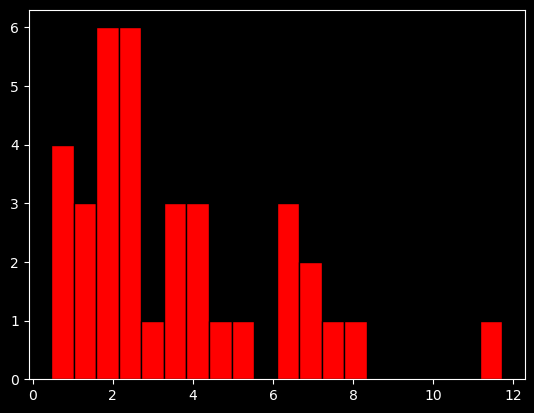

In [11]:
hdata = DIVS['DIV19']['Mean Firing Rate (hz)']
plt.hist(hdata[['unt2']], bins=20, color=f'red', edgecolor='black')
hdata

(array([3., 4., 0., 3., 1., 1., 1., 3., 2., 1., 0., 5., 2., 2., 3., 2., 1.,
        0., 1., 1.]),
 array([0.065461  , 0.09747535, 0.1294897 , 0.16150405, 0.1935184 ,
        0.22553275, 0.2575471 , 0.28956145, 0.3215758 , 0.35359015,
        0.3856045 , 0.41761885, 0.4496332 , 0.48164755, 0.5136619 ,
        0.54567625, 0.5776906 , 0.60970495, 0.6417193 , 0.67373365,
        0.705748  ]),
 <BarContainer object of 20 artists>)

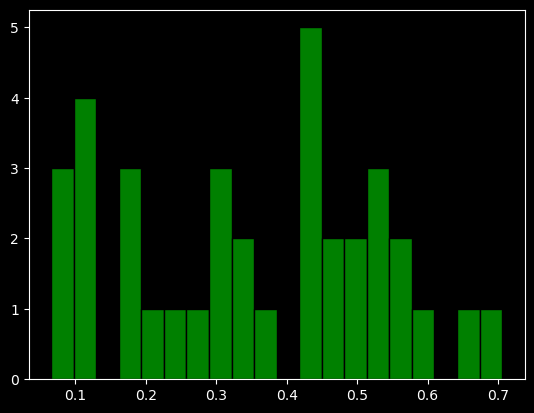

In [12]:
hdata = DIVSU['DIV5'][('Mean Firing Rate (hz)')]
plt.hist(hdata, bins=20, color=f'green', edgecolor='black')


In [13]:
## transform data int s x f

sf = pd.DataFrame(columns=DIVSU['DIV10'].keys())
sf['DIV'] = int
for day, testdct in tqdm(DIVSU.items()):
    # for t, df in testdct.items():
    new_rowd= {k: list(d[['unt2']].values.flatten()) for k,d in testdct.items()}
    new_rowd['DIV'] = [day]* len(list(testdct.values())[0]['unt2'])
    lofd = []
    length = (len(next(iter(new_rowd.values()))))
    if length!= 36:
        print(new_rowd)
    for i in range(length):
        positionaldict = {key: value[i] for key, value in new_rowd.items()}
        lofd.append(positionaldict)
    smrow = pd.DataFrame(lofd)
    sf = pd.concat([sf, smrow], ignore_index=True)

sf.reset_index(drop=True, inplace=True)
sf

100%|██████████| 12/12 [00:00<00:00, 397.59it/s]


,Mean Firing Rate (hz),Number of Active Electrodes,Weighted Mean Firing Rate (Hz),Number of Bursting Electrodes,Burst Frequency - Avg (Hz),Burst Duration - Avg (s),Normalized Duration IQR - Avg,IBI Coefficient of Variation - Avg,Burst Percentage - Avg,Network Burst Frequency (Hz),Network Burst Duration - Avg (sec),Network Burst Percentage,Network IBI Coefficient of Variation,Network Normalized Duration IQR,Area Under Normalized Cross-Correlation,Resistance - Avg (kOhms),Number of Covered Electrodes,DIV
0,0.561301,6.0,0.736169,6.0,0.029747,0.234593,0.711902,1.050947,46.088488,0.023353,0.483063,60.178306,1.415529,0.350515,0.294919,38.147218,7.0,DIV5
1,0.564012,8.0,0.564012,8.0,0.024604,0.203513,0.542146,1.972837,77.754092,0.026689,0.317410,83.216266,2.238182,0.376812,0.577931,42.756379,8.0,DIV5
2,0.418057,5.0,0.666222,5.0,0.028691,0.232495,0.815116,0.711294,51.257545,0.023353,0.418074,63.042394,0.648333,0.493827,0.323032,38.896790,6.0,DIV5
3,0.525021,7.0,0.600024,7.0,0.026689,0.212352,0.720098,0.705657,70.892747,0.018349,0.590858,58.101668,0.739722,0.336000,0.344386,42.377527,7.0,DIV5
4,0.642827,7.0,0.723698,8.0,0.018140,0.248472,1.014907,0.794031,52.857241,0.010008,0.582107,42.912747,0.658743,0.091743,0.419073,41.521664,8.0,DIV5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,1.659138,8.0,1.659138,8.0,0.053743,0.235815,0.574510,4.728524,97.834243,0.045169,0.537769,99.873960,4.329987,0.746667,0.834162,42.925229,8.0,DIV19
428,0.734003,8.0,0.734003,8.0,0.015475,0.325415,0.518204,0.583986,90.883361,0.016729,0.476616,89.145299,0.619464,1.063291,0.846910,42.116889,8.0,DIV19
429,2.397742,8.0,2.397742,8.0,0.087829,0.342462,0.663808,2.338972,91.631227,0.026767,0.785745,62.855399,2.295133,0.251572,0.730128,40.034007,8.0,DIV19
430,7.098703,8.0,7.098703,8.0,0.162484,0.224156,0.604592,0.760791,97.763975,0.153910,0.430532,98.285512,0.720077,0.385542,0.883158,39.453970,8.0,DIV19


In [14]:
## box cox on each feature individually, all DIV
## box cox on all. looks good , more normally distributed on the histogram
def box_cox(dr):
    # dr = feature_data.replace(0, 1e-20)
    original_shape, cols = dr.shape, dr.columns# Save the original shape
    dr = (dr.to_numpy().flatten())
    bc_data, fit_lambda = stats.boxcox(dr)    
    bcdatar = np.reshape(bc_data, original_shape)
    bcdf = pd.DataFrame(bcdatar, columns=cols)
    return fit_lambda, bcdf

def log_n(value):
    out = np.log(1+ value)
    return out

def logx(value):
    out = np.log(value)
    print(out)
    return out
sf = sf.replace(0, 1e-20)
BC_LAMBDAS = {feature: float for feature in sf.columns if feature != 'DIV'}
BC_sf = pd.DataFrame(index=sf.index)
notBC = ['Electrode', 'Resistance', 'Percentage', 'DIV']
for col in sf.columns:
    if not any(x.casefold() in col.casefold() for x in notBC):
        print(col)
        lambd, df = box_cox(sf[[col]])
        BC_LAMBDAS[col] = lambd
        BC_sf[col] = df[col]
    # elif 'Electrode'.casefold() in col.casefold():
    #     BC_sf[col] = sf[col].apply(log_n)
    #     BC_LAMBDAS[col] = 0

        # BC_sf[col] = sf[col]
    # elif 'Resistance'.casefold() in col.casefold() or 'Percentage'.casefold() in col.casefold():
    if 'Percentage'.casefold() in col.casefold():
        BC_sf[col] = sf[col].apply(logx)
        BC_LAMBDAS[col] = 0

    # else:
    #     BC_LAMBDAS[col] = 0
    #     BC_sf[col] = sf[col]
BC_sf['DIV'] = sf['DIV']
# BC_LAMBDAS

Mean Firing Rate (hz)
Weighted Mean Firing Rate (Hz)
Burst Frequency - Avg (Hz)
Burst Duration - Avg (s)
Normalized Duration IQR - Avg
IBI Coefficient of Variation - Avg
3.8305632008135317
4.353551179899502
3.9368628266949837
4.261168129292487
3.9675947133379896
4.081269825826663
4.054259206039414
2.78705797341485
3.9480003877424825
4.1077789980446395
4.099283114141793
3.935224086726345
2.8958102203915095
3.897444736972702
3.1674283712303026
3.8968227039644345
2.505154357759642
3.9149758813954816
2.8511510269651055
3.6691899824154204
3.7124770039272303
3.990298460121946
3.5420979219654205
3.420394041083156
3.6210761694308093
3.931121168961712
3.5105657053174975
3.6663071046761915
2.959529334337029
3.6789868330955238
3.3290893416436296
3.2135924121916046
3.6319618465719414
3.261110261422405
4.226253401718952
4.204503810522917
4.420229654672341
4.442434574192873
4.32507609187431
4.518387495574966
4.523685526701838
4.329197912119578
4.361995417753084
4.33439303018139
4.441195479714261
4.3

In [15]:
BC_sf

,Mean Firing Rate (hz),Weighted Mean Firing Rate (Hz),Burst Frequency - Avg (Hz),Burst Duration - Avg (s),Normalized Duration IQR - Avg,IBI Coefficient of Variation - Avg,Burst Percentage - Avg,Network Burst Frequency (Hz),Network Burst Duration - Avg (sec),Network Burst Percentage,Network IBI Coefficient of Variation,Network Normalized Duration IQR,Area Under Normalized Cross-Correlation,DIV
0,-0.514064,-0.291063,-1.531645,-1.112051,-0.337409,0.049467,3.830563,-1.594253,-0.670173,4.097312,0.343628,-0.919438,-0.492695,DIV5
1,-0.510260,-0.520956,-1.556573,-1.191351,-0.604439,0.639102,4.353551,-1.576503,-1.009047,4.421443,0.785038,-0.863610,-0.348019,DIV5
2,-0.732915,-0.379642,-1.536599,-1.117192,-0.203552,-0.351463,3.936863,-1.594253,-0.790464,4.143807,-0.439479,-0.645508,-0.481786,DIV5
3,-0.566045,-0.469361,-1.546215,-1.168080,-0.326121,-0.359935,4.261168,-1.623204,-0.495688,4.062194,-0.304439,-0.951600,-0.472968,DIV5
4,-0.404068,-0.306433,-1.591427,-1.078731,0.014802,-0.235546,3.967595,-1.681149,-0.508892,3.759169,-0.423106,-1.786932,-0.438607,DIV5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,0.562842,0.551909,-1.434479,-1.109069,-0.547856,1.353106,4.583275,-1.492461,-0.578244,4.603909,1.398264,-0.281478,-0.154631,DIV19
428,-0.290392,-0.293720,-1.607361,-0.912144,-0.648421,-0.565114,4.509577,-1.633326,-0.681527,4.490268,-0.486393,0.061853,-0.143548,DIV19
429,1.052393,1.016567,-1.325228,-0.878626,-0.406267,0.787211,4.517772,-1.576101,-0.234581,4.140837,0.808870,-1.162561,-0.239965,DIV19
430,3.012178,2.773582,-1.138109,-1.137916,-0.497937,-0.280320,4.582556,-1.171444,-0.766340,4.587877,-0.331909,-0.845719,-0.111298,DIV19


In [16]:
## no need to transpose, sf yields fxf correlation
# fs = sf.transpose()
# fs.index

In [17]:
BC_sf

,Mean Firing Rate (hz),Weighted Mean Firing Rate (Hz),Burst Frequency - Avg (Hz),Burst Duration - Avg (s),Normalized Duration IQR - Avg,IBI Coefficient of Variation - Avg,Burst Percentage - Avg,Network Burst Frequency (Hz),Network Burst Duration - Avg (sec),Network Burst Percentage,Network IBI Coefficient of Variation,Network Normalized Duration IQR,Area Under Normalized Cross-Correlation,DIV
0,-0.514064,-0.291063,-1.531645,-1.112051,-0.337409,0.049467,3.830563,-1.594253,-0.670173,4.097312,0.343628,-0.919438,-0.492695,DIV5
1,-0.510260,-0.520956,-1.556573,-1.191351,-0.604439,0.639102,4.353551,-1.576503,-1.009047,4.421443,0.785038,-0.863610,-0.348019,DIV5
2,-0.732915,-0.379642,-1.536599,-1.117192,-0.203552,-0.351463,3.936863,-1.594253,-0.790464,4.143807,-0.439479,-0.645508,-0.481786,DIV5
3,-0.566045,-0.469361,-1.546215,-1.168080,-0.326121,-0.359935,4.261168,-1.623204,-0.495688,4.062194,-0.304439,-0.951600,-0.472968,DIV5
4,-0.404068,-0.306433,-1.591427,-1.078731,0.014802,-0.235546,3.967595,-1.681149,-0.508892,3.759169,-0.423106,-1.786932,-0.438607,DIV5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,0.562842,0.551909,-1.434479,-1.109069,-0.547856,1.353106,4.583275,-1.492461,-0.578244,4.603909,1.398264,-0.281478,-0.154631,DIV19
428,-0.290392,-0.293720,-1.607361,-0.912144,-0.648421,-0.565114,4.509577,-1.633326,-0.681527,4.490268,-0.486393,0.061853,-0.143548,DIV19
429,1.052393,1.016567,-1.325228,-0.878626,-0.406267,0.787211,4.517772,-1.576101,-0.234581,4.140837,0.808870,-1.162561,-0.239965,DIV19
430,3.012178,2.773582,-1.138109,-1.137916,-0.497937,-0.280320,4.582556,-1.171444,-0.766340,4.587877,-0.331909,-0.845719,-0.111298,DIV19


In [18]:
BC_sfDIVS = BC_sf['DIV']
BC_sf.drop(columns=['DIV'], inplace=True)
BC_sf = BC_sf.apply(pd.to_numeric, errors = 'coerce')
BC_sf

##mirror for sf too
sf.drop(columns=['DIV'], inplace=True)
sf = sf.apply(pd.to_numeric, errors = 'coerce')
sf

,Mean Firing Rate (hz),Number of Active Electrodes,Weighted Mean Firing Rate (Hz),Number of Bursting Electrodes,Burst Frequency - Avg (Hz),Burst Duration - Avg (s),Normalized Duration IQR - Avg,IBI Coefficient of Variation - Avg,Burst Percentage - Avg,Network Burst Frequency (Hz),Network Burst Duration - Avg (sec),Network Burst Percentage,Network IBI Coefficient of Variation,Network Normalized Duration IQR,Area Under Normalized Cross-Correlation,Resistance - Avg (kOhms),Number of Covered Electrodes
0,0.561301,6.0,0.736169,6.0,0.029747,0.234593,0.711902,1.050947,46.088488,0.023353,0.483063,60.178306,1.415529,0.350515,0.294919,38.147218,7.0
1,0.564012,8.0,0.564012,8.0,0.024604,0.203513,0.542146,1.972837,77.754092,0.026689,0.317410,83.216266,2.238182,0.376812,0.577931,42.756379,8.0
2,0.418057,5.0,0.666222,5.0,0.028691,0.232495,0.815116,0.711294,51.257545,0.023353,0.418074,63.042394,0.648333,0.493827,0.323032,38.896790,6.0
3,0.525021,7.0,0.600024,7.0,0.026689,0.212352,0.720098,0.705657,70.892747,0.018349,0.590858,58.101668,0.739722,0.336000,0.344386,42.377527,7.0
4,0.642827,7.0,0.723698,8.0,0.018140,0.248472,1.014907,0.794031,52.857241,0.010008,0.582107,42.912747,0.658743,0.091743,0.419073,41.521664,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,1.659138,8.0,1.659138,8.0,0.053743,0.235815,0.574510,4.728524,97.834243,0.045169,0.537769,99.873960,4.329987,0.746667,0.834162,42.925229,8.0
428,0.734003,8.0,0.734003,8.0,0.015475,0.325415,0.518204,0.583986,90.883361,0.016729,0.476616,89.145299,0.619464,1.063291,0.846910,42.116889,8.0
429,2.397742,8.0,2.397742,8.0,0.087829,0.342462,0.663808,2.338972,91.631227,0.026767,0.785745,62.855399,2.295133,0.251572,0.730128,40.034007,8.0
430,7.098703,8.0,7.098703,8.0,0.162484,0.224156,0.604592,0.760791,97.763975,0.153910,0.430532,98.285512,0.720077,0.385542,0.883158,39.453970,8.0


In [19]:
BC_LAMBDAS

{'Mean Firing Rate (hz)': 0.4110992814766048,
 'Number of Active Electrodes': float,
 'Weighted Mean Firing Rate (Hz)': 0.33597288969070077,
 'Number of Bursting Electrodes': float,
 'Burst Frequency - Avg (Hz)': 0.5624940275594701,
 'Burst Duration - Avg (s)': 0.383684196197027,
 'Normalized Duration IQR - Avg': 0.04187367310692782,
 'IBI Coefficient of Variation - Avg': -0.18217655106155956,
 'Burst Percentage - Avg': 0,
 'Network Burst Frequency (Hz)': 0.5468766805917464,
 'Network Burst Duration - Avg (sec)': 0.22920569421109394,
 'Network Burst Percentage': 0,
 'Network IBI Coefficient of Variation': -0.0646617672297916,
 'Network Normalized Duration IQR': 0.25604421205023914,
 'Area Under Normalized Cross-Correlation': 1.8059057541066568,
 'Resistance - Avg (kOhms)': float,
 'Number of Covered Electrodes': float}

Mean Firing Rate (hz) 8.884365794636306


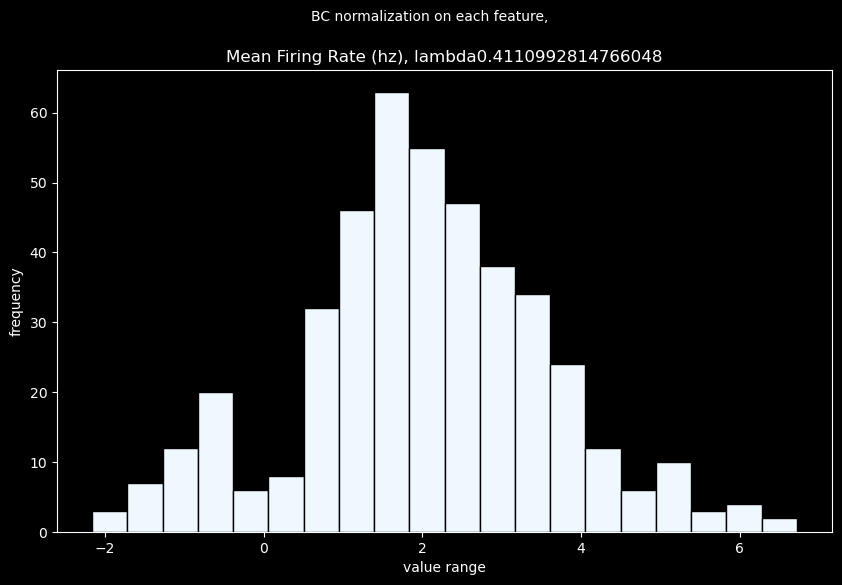

Weighted Mean Firing Rate (Hz) 7.238078907086612


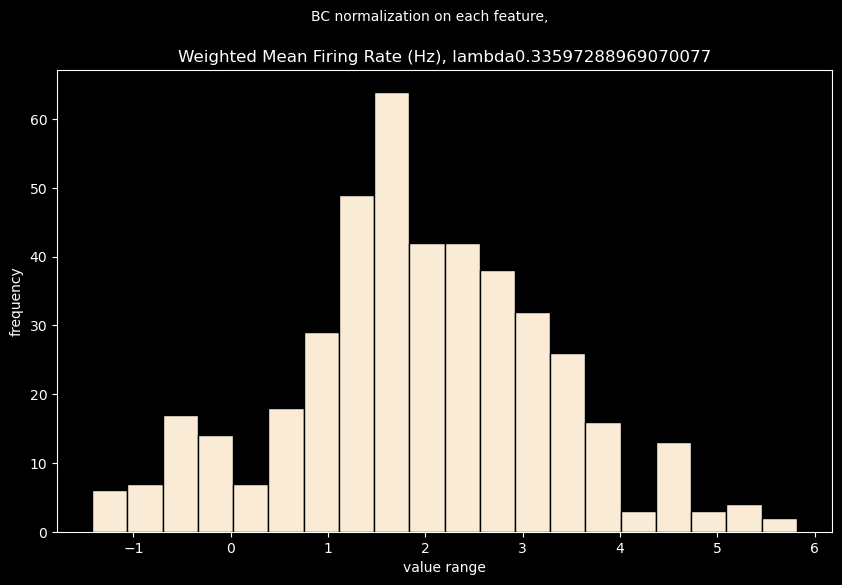

Burst Frequency - Avg (Hz) 1.291943727605051


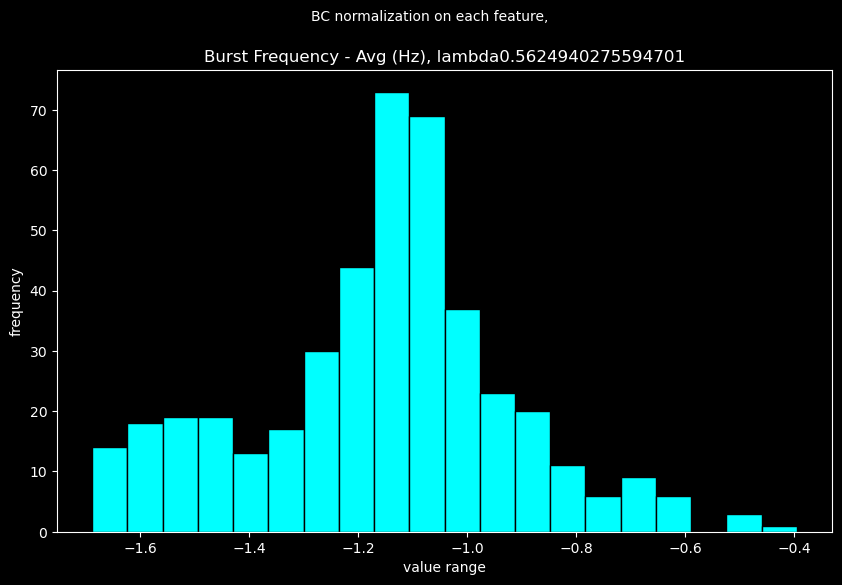

Burst Duration - Avg (s) 1.326961777126388


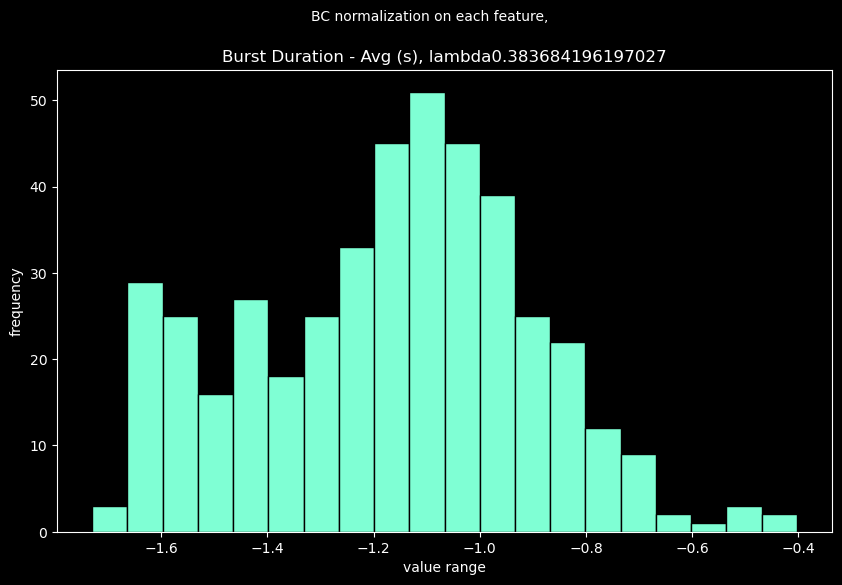

Normalized Duration IQR - Avg 3.6097356418509725


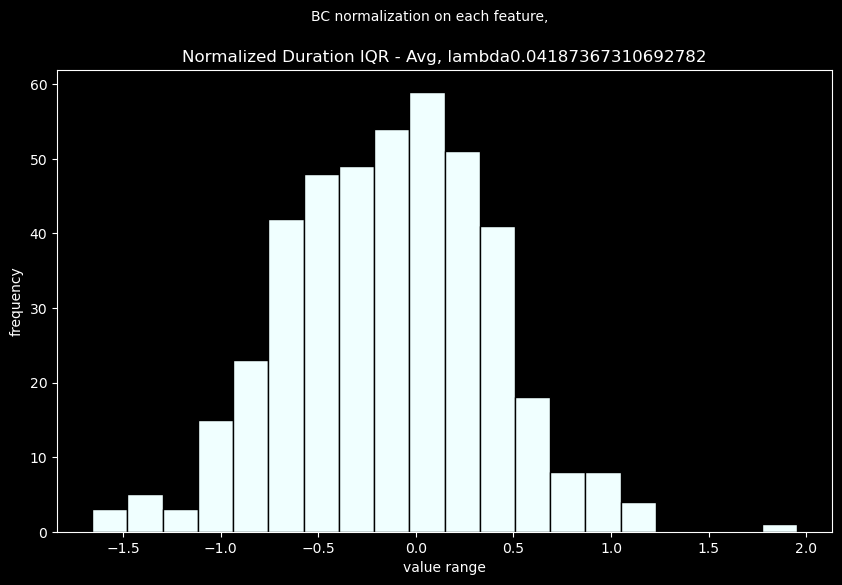

IBI Coefficient of Variation - Avg 3.8644729485321516


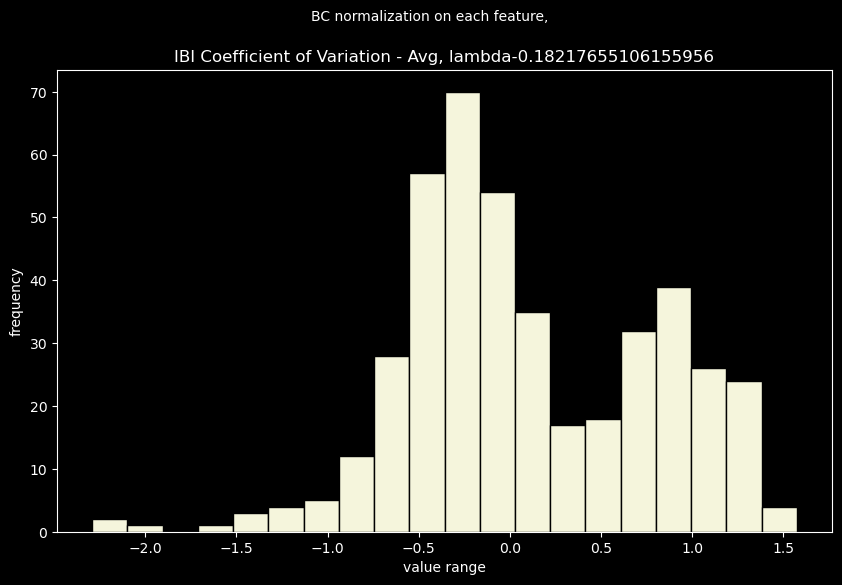

Burst Percentage - Avg 50.65555117390159


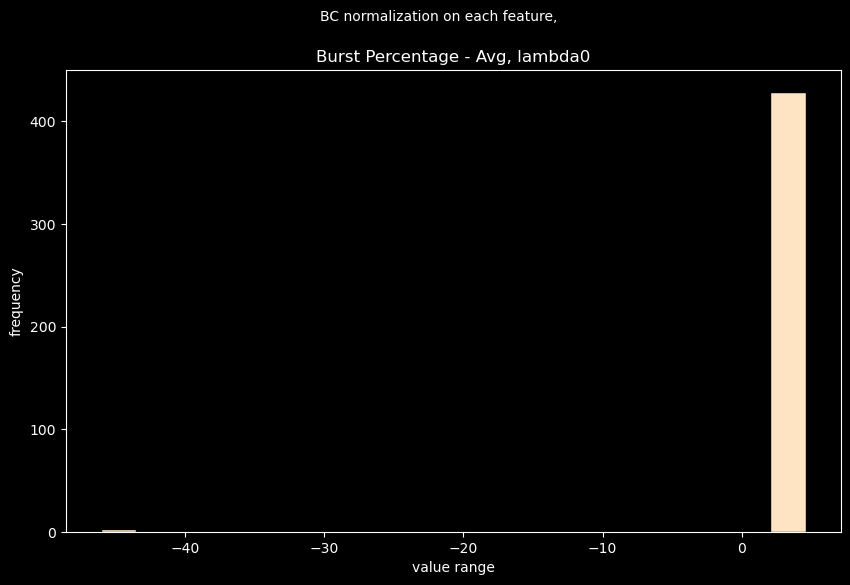

Network Burst Frequency (Hz) 1.2664679158356655


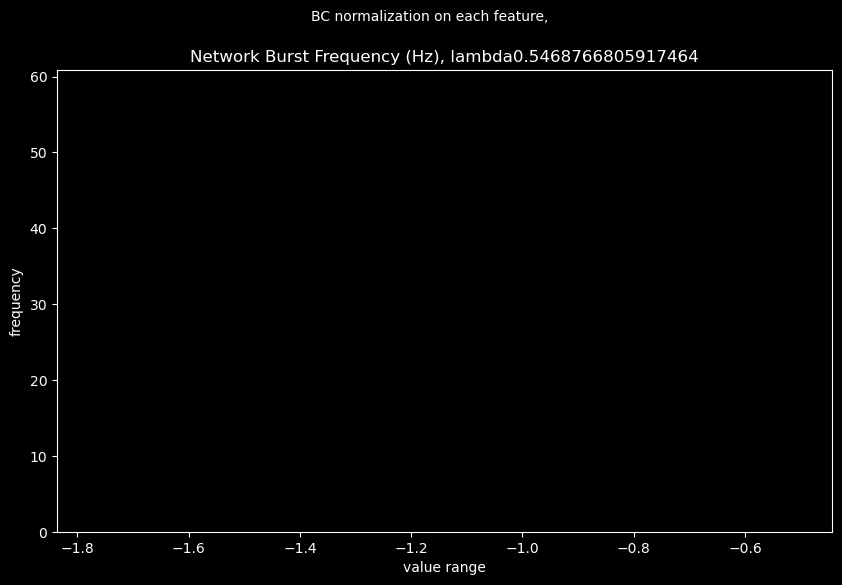

Network Burst Duration - Avg (sec) 2.1474064725724538


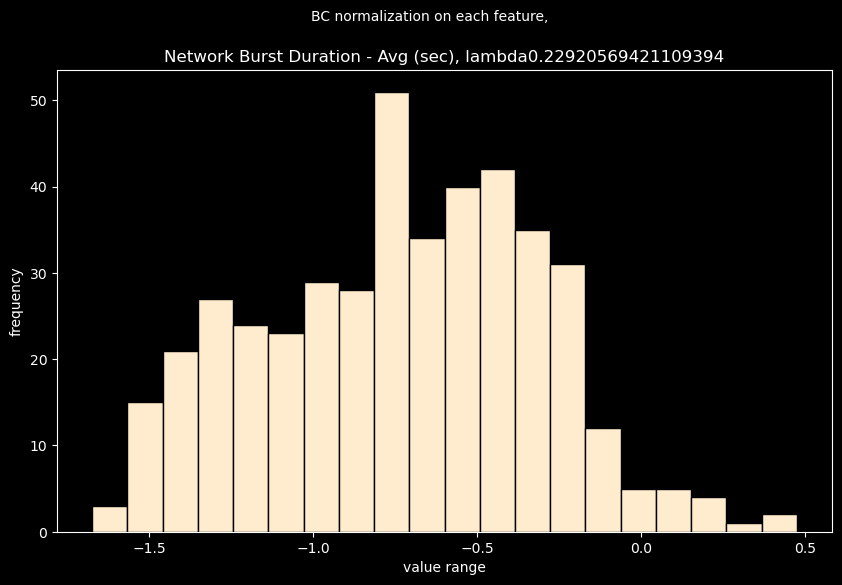

Network Burst Percentage 3.316958705468467


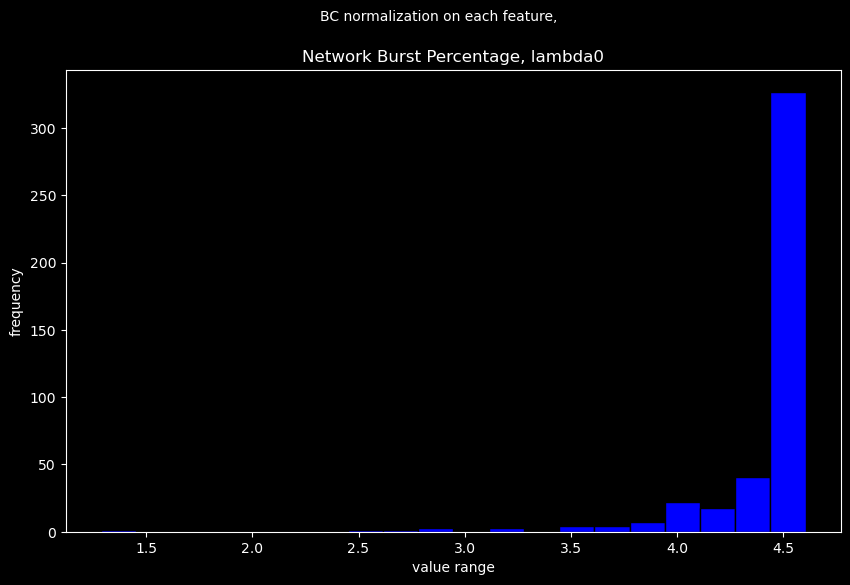

Network IBI Coefficient of Variation 3.92599633585057


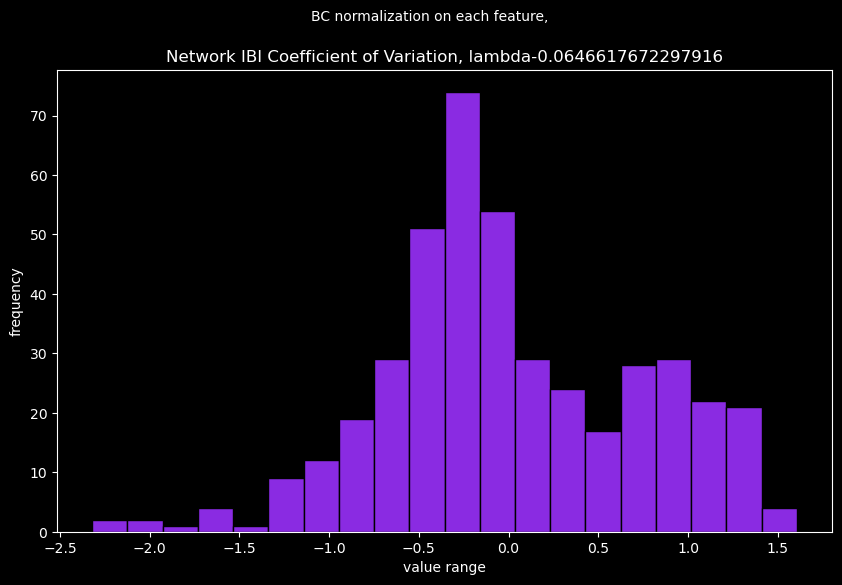

Network Normalized Duration IQR 7.467485589677613


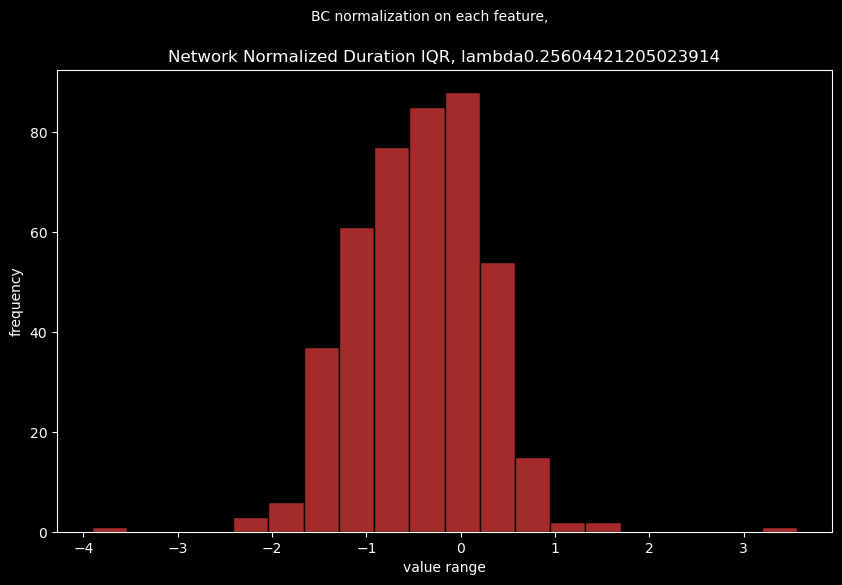

Area Under Normalized Cross-Correlation 0.5675224045241477


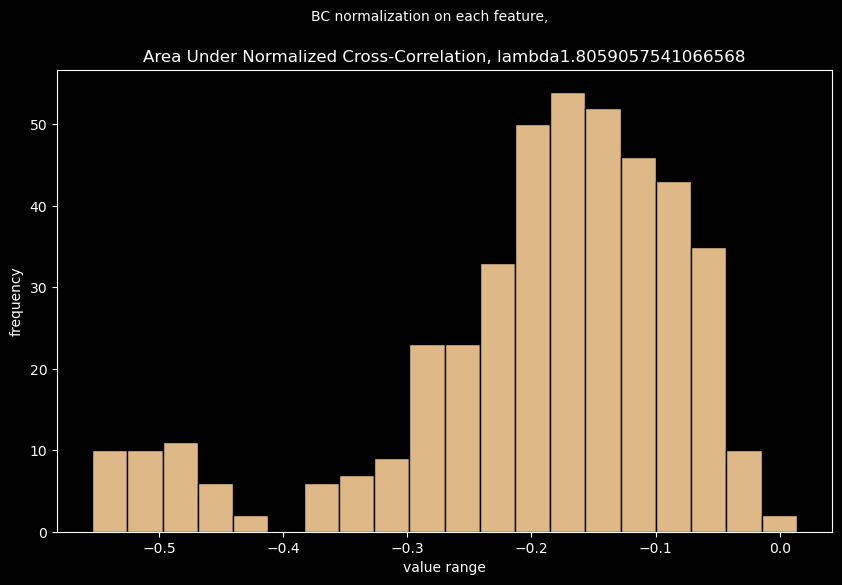

In [20]:
colors = list(matplotlib.colors.cnames.keys())

for i, col in enumerate(BC_sf.columns):
        valrange = BC_sf[col].max() - BC_sf[col].min()
        print(col , valrange)
        plt.figure(figsize=(10, 6)) 
        hdata = BC_sf[col].values  # Correct way to access column values
        color_index = i % len(colors)  # To cycle back to the start if you run out of unique colors
        plt.hist(hdata, bins=20, color=colors[color_index], edgecolor='black')
        plt.suptitle(f'BC normalization on each feature, ', fontsize=10)
        plt.title(f'{col}, lambda{BC_LAMBDAS[col]}')
        SAVE_FILE = f'../plots/histograms/BoxCox&Log/{os.path.basename(os.path.normpath(FOLDER_PATH))}/'\
                f'features/{col}.png'
        ensure_dirs_exists(SAVE_FILE)
        plt.xlabel('value range')
        plt.ylabel('frequency')
        plt.savefig(SAVE_FILE)
        plt.show()


In [21]:
# BC_sf.to_csv('Show_Rohit_BCnorm.csv')

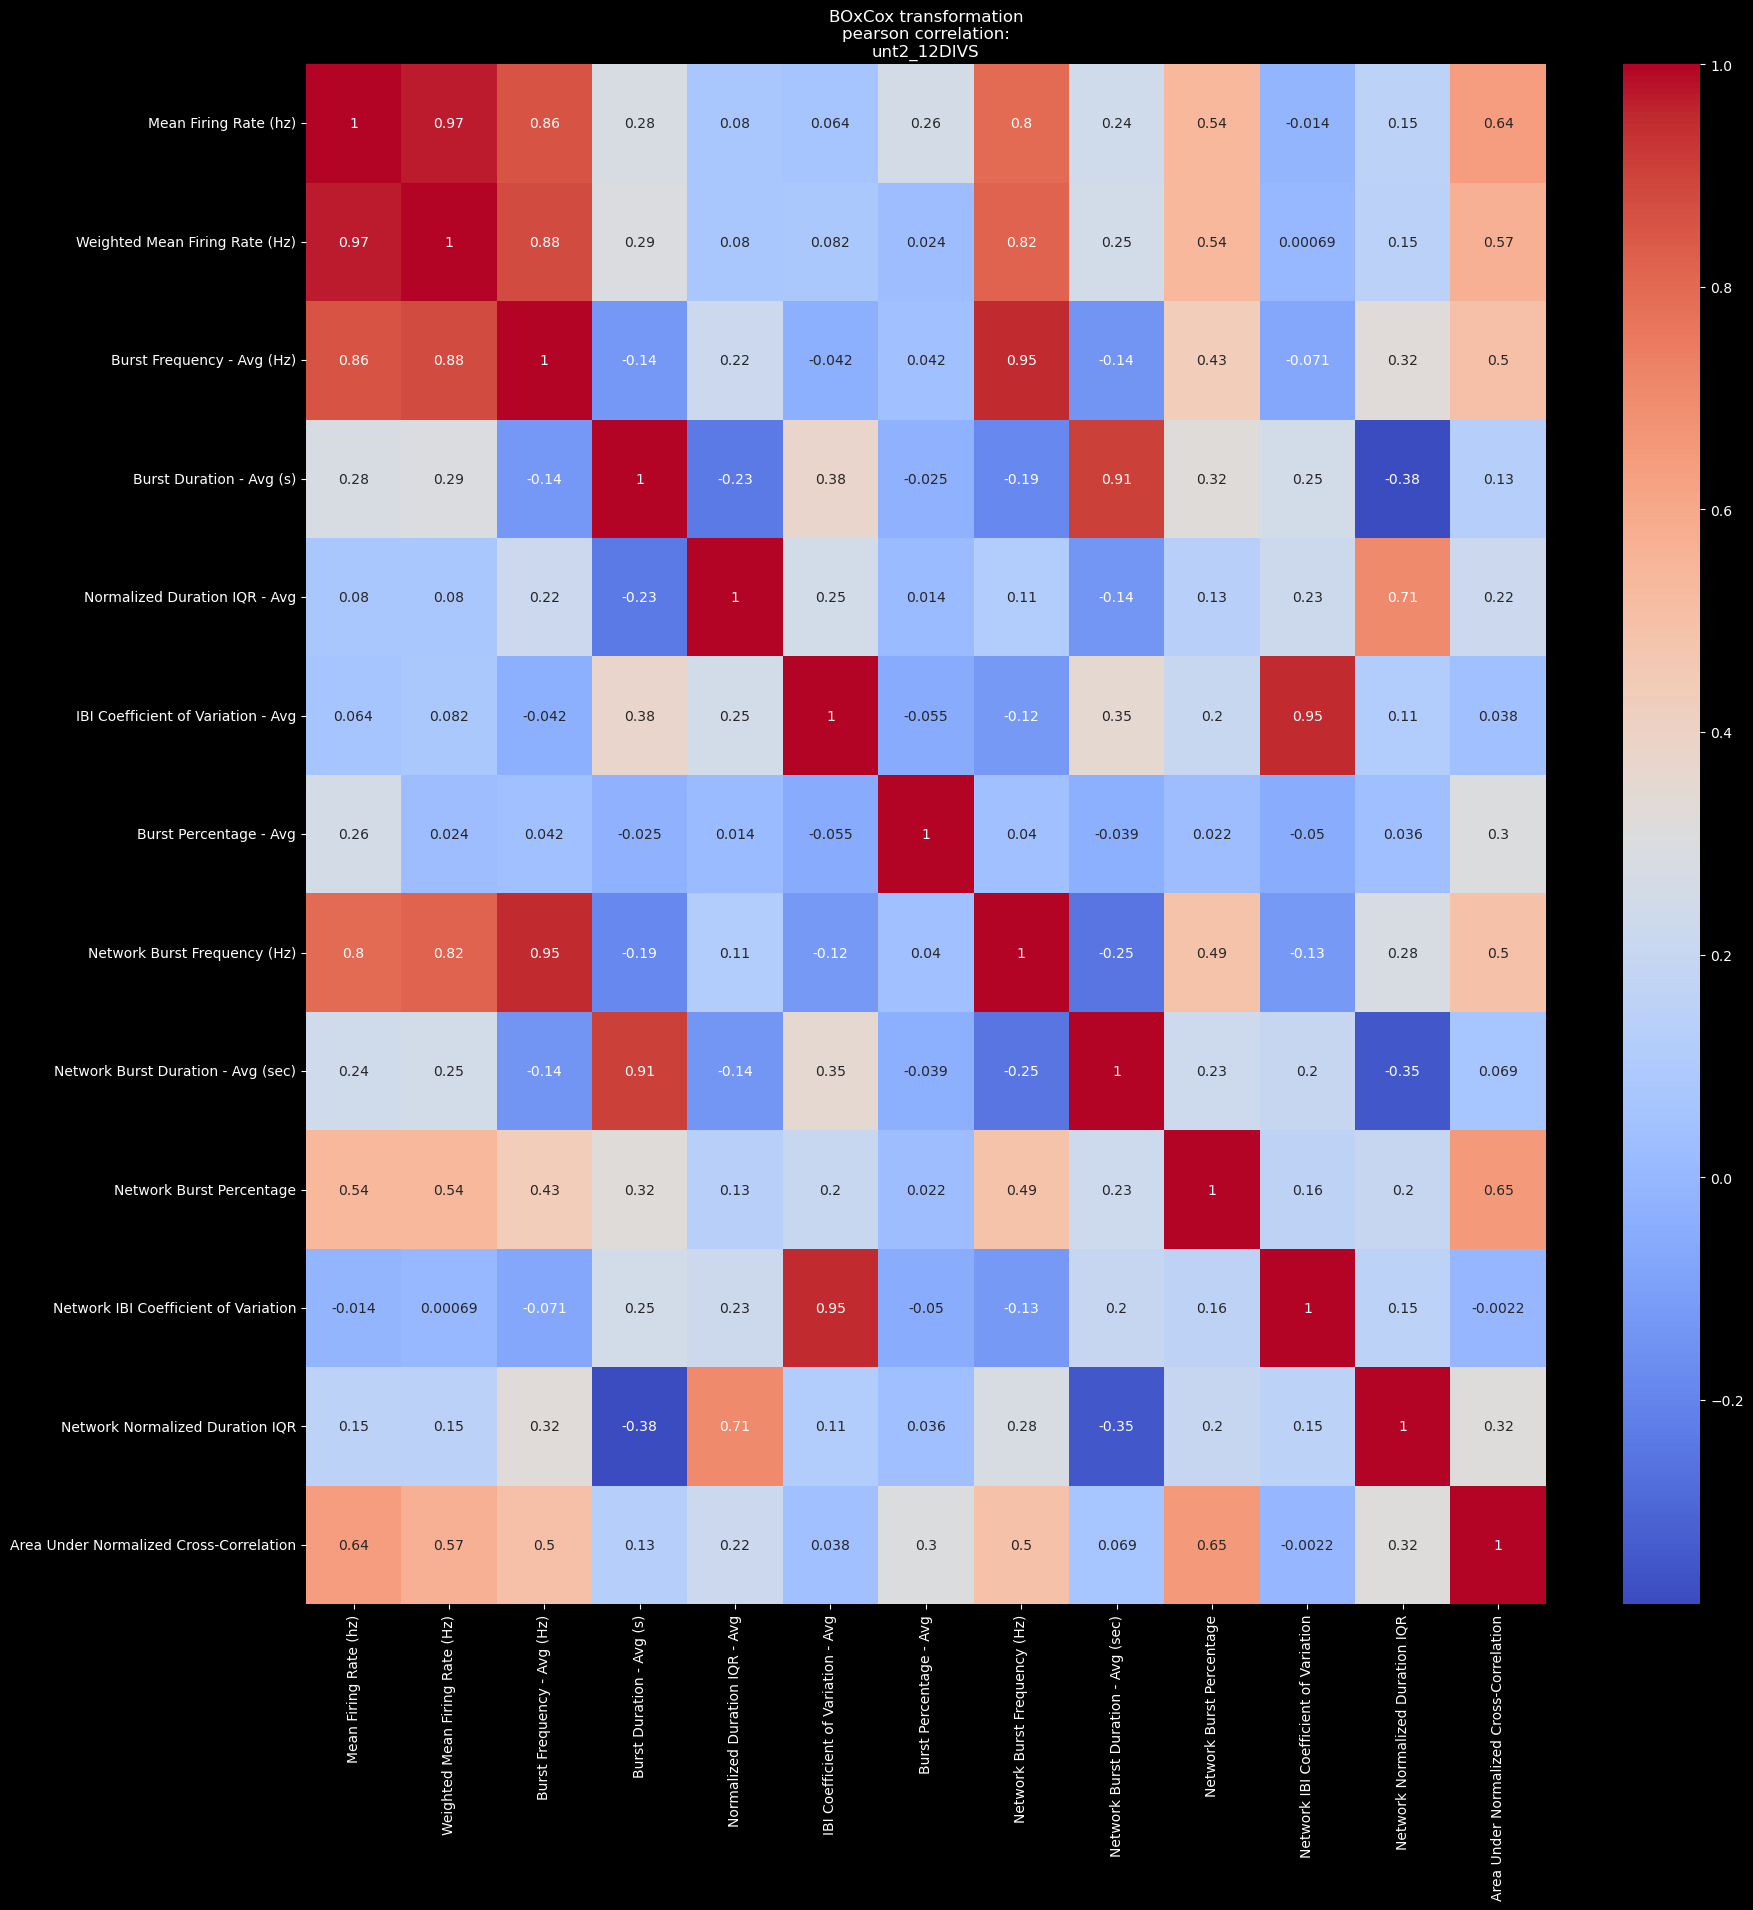

In [22]:
import seaborn as sns
type = 'pearson'
CORRS = (BC_sf.corr(method=type))
# print(CORRS)
# pearsonHM[key]= 
plt.figure(figsize=(20, 20))
ax = sns.heatmap(CORRS, annot=True, cmap='coolwarm')
plt.title(f'BOxCox transformation\n{type} correlation:\nunt2_12DIVS')
SAVE_FILE = f'../plots/heatmaps/BoxCox&Log/{os.path.basename(os.path.normpath(FOLDER_PATH))}/'\
            f'{type} Correlations.png'
ensure_dirs_exists(SAVE_FILE)
plt.savefig(SAVE_FILE)
plt.show()

In [23]:
sf

,Mean Firing Rate (hz),Number of Active Electrodes,Weighted Mean Firing Rate (Hz),Number of Bursting Electrodes,Burst Frequency - Avg (Hz),Burst Duration - Avg (s),Normalized Duration IQR - Avg,IBI Coefficient of Variation - Avg,Burst Percentage - Avg,Network Burst Frequency (Hz),Network Burst Duration - Avg (sec),Network Burst Percentage,Network IBI Coefficient of Variation,Network Normalized Duration IQR,Area Under Normalized Cross-Correlation,Resistance - Avg (kOhms),Number of Covered Electrodes
0,0.561301,6.0,0.736169,6.0,0.029747,0.234593,0.711902,1.050947,46.088488,0.023353,0.483063,60.178306,1.415529,0.350515,0.294919,38.147218,7.0
1,0.564012,8.0,0.564012,8.0,0.024604,0.203513,0.542146,1.972837,77.754092,0.026689,0.317410,83.216266,2.238182,0.376812,0.577931,42.756379,8.0
2,0.418057,5.0,0.666222,5.0,0.028691,0.232495,0.815116,0.711294,51.257545,0.023353,0.418074,63.042394,0.648333,0.493827,0.323032,38.896790,6.0
3,0.525021,7.0,0.600024,7.0,0.026689,0.212352,0.720098,0.705657,70.892747,0.018349,0.590858,58.101668,0.739722,0.336000,0.344386,42.377527,7.0
4,0.642827,7.0,0.723698,8.0,0.018140,0.248472,1.014907,0.794031,52.857241,0.010008,0.582107,42.912747,0.658743,0.091743,0.419073,41.521664,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,1.659138,8.0,1.659138,8.0,0.053743,0.235815,0.574510,4.728524,97.834243,0.045169,0.537769,99.873960,4.329987,0.746667,0.834162,42.925229,8.0
428,0.734003,8.0,0.734003,8.0,0.015475,0.325415,0.518204,0.583986,90.883361,0.016729,0.476616,89.145299,0.619464,1.063291,0.846910,42.116889,8.0
429,2.397742,8.0,2.397742,8.0,0.087829,0.342462,0.663808,2.338972,91.631227,0.026767,0.785745,62.855399,2.295133,0.251572,0.730128,40.034007,8.0
430,7.098703,8.0,7.098703,8.0,0.162484,0.224156,0.604592,0.760791,97.763975,0.153910,0.430532,98.285512,0.720077,0.385542,0.883158,39.453970,8.0


In [24]:
BC_sf

,Mean Firing Rate (hz),Weighted Mean Firing Rate (Hz),Burst Frequency - Avg (Hz),Burst Duration - Avg (s),Normalized Duration IQR - Avg,IBI Coefficient of Variation - Avg,Burst Percentage - Avg,Network Burst Frequency (Hz),Network Burst Duration - Avg (sec),Network Burst Percentage,Network IBI Coefficient of Variation,Network Normalized Duration IQR,Area Under Normalized Cross-Correlation
0,-0.514064,-0.291063,-1.531645,-1.112051,-0.337409,0.049467,3.830563,-1.594253,-0.670173,4.097312,0.343628,-0.919438,-0.492695
1,-0.510260,-0.520956,-1.556573,-1.191351,-0.604439,0.639102,4.353551,-1.576503,-1.009047,4.421443,0.785038,-0.863610,-0.348019
2,-0.732915,-0.379642,-1.536599,-1.117192,-0.203552,-0.351463,3.936863,-1.594253,-0.790464,4.143807,-0.439479,-0.645508,-0.481786
3,-0.566045,-0.469361,-1.546215,-1.168080,-0.326121,-0.359935,4.261168,-1.623204,-0.495688,4.062194,-0.304439,-0.951600,-0.472968
4,-0.404068,-0.306433,-1.591427,-1.078731,0.014802,-0.235546,3.967595,-1.681149,-0.508892,3.759169,-0.423106,-1.786932,-0.438607
...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,0.562842,0.551909,-1.434479,-1.109069,-0.547856,1.353106,4.583275,-1.492461,-0.578244,4.603909,1.398264,-0.281478,-0.154631
428,-0.290392,-0.293720,-1.607361,-0.912144,-0.648421,-0.565114,4.509577,-1.633326,-0.681527,4.490268,-0.486393,0.061853,-0.143548
429,1.052393,1.016567,-1.325228,-0.878626,-0.406267,0.787211,4.517772,-1.576101,-0.234581,4.140837,0.808870,-1.162561,-0.239965
430,3.012178,2.773582,-1.138109,-1.137916,-0.497937,-0.280320,4.582556,-1.171444,-0.766340,4.587877,-0.331909,-0.845719,-0.111298


In [25]:
pca_df

NameError: name 'pca_df' is not defined

In [46]:
## PCA on BC and log
import plotly.express as px
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
plt.figure(figsize=(10, 6))

pca = PCA(n_components=13)
principalComponent = pca.fit_transform(BC_sf)
## convert principalComponent np array to df 
pca_df = pd.DataFrame(data = principalComponent, columns = [f'PC{i}' for i in range(1, 14)])
pca_df['DIV'] = BC_sfDIVS 

## remove Outliers
OUT = pca_df[['PC1']] > 10
keep = ~OUT.any(axis=1)
pca_df = pca_df[keep]

## avg all replicates for each DIV along test
pca_avg = pca_df.groupby('DIV', as_index=False).mean()
pca_avg
# ex_var = pca.explained_variance_ratio_
# print(pca.singular_values_)
# fig = px.scatter_matrix(
#     components,
#     labels=labels,
#     dimensions=range(4),
#     color=1,
#     title = f'pca'
# )
# fig.update_traces(diagonal_visible=False)
# SAVE_FILE = f'../plots/PCA/BoxCox/{os.path.basename(os.path.normpath(FOLDER_PATH))}/'\
#     f'12DIVs_unt2.png'
# ensure_dirs_exists(SAVE_FILE)
# plt.savefig(SAVE_FILE)
# fig.show()

,DIV,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,DIV10,-0.268015,-0.618325,0.233169,0.931485,-0.320659,-0.080230,-0.081356,0.006797,-0.035744,-0.002722,-0.014620,0.004617,-0.004147
1,DIV11,-0.421577,0.083212,0.375876,0.997876,-0.020277,0.043355,-0.069759,0.031922,-0.006815,0.015342,0.005898,0.023138,-0.023592
2,DIV12,-0.526721,0.697465,0.394563,0.036836,0.089109,0.030778,-0.059748,0.012771,0.006678,-0.014466,-0.019810,0.026608,-0.015710
3,DIV13,-0.671526,1.874217,0.840073,-0.429640,-0.034486,0.045466,-0.017429,-0.017187,0.016988,-0.001042,0.024104,0.001824,-0.006440
4,DIV14,-0.675559,2.168988,-0.140119,0.226084,0.264690,0.040289,0.150929,0.048040,0.002084,-0.004054,0.023810,-0.019964,0.011767
5,DIV15,-0.616919,1.670467,-0.643856,-0.162820,-0.017222,-0.030223,0.050856,0.012924,0.036104,-0.048242,-0.002113,0.013143,0.000994
6,DIV16,-0.545119,0.827795,-0.631473,-0.555513,-0.056038,-0.015933,-0.057881,-0.021559,0.007386,-0.022909,-0.018089,0.012468,-0.007259
7,DIV17,-0.475887,0.099018,-0.140404,-0.748869,0.091888,0.083515,-0.112147,0.021884,-0.018507,0.042562,-0.005470,0.009395,0.004222
8,DIV18,-0.348277,-0.895676,-0.582903,-0.192289,0.062302,0.170727,-0.097476,-0.003525,-0.001464,0.021811,0.007588,-0.009235,0.005705
9,DIV19,-0.368426,-0.816304,-0.518459,-0.312146,0.210172,0.108952,-0.126869,-0.018711,-0.020573,0.048250,-0.000136,0.005018,0.001590


<Figure size 1000x600 with 0 Axes>

In [53]:

# colors = list(mcolors.CSS4_COLORS.values())[:17]  # Get the first 17 colors from the CSS4_COLORS dictionary
colors = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', 
    '#d62728', # Replaced invalid color with a valid hex color
    '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#7fc97f', '#beaed4', 
    '#fdc086', '#ffff99', '#386cb0'
]
xa = 'PC4'
ya = 'PC5'
# Assuming colors is your list of 17 colors
color_map = {div_value: color for div_value, color in zip( pca_df['DIV'].unique(), colors)}

fig = px.scatter(pca_df, x=xa, y=ya, color='DIV', 
                 title='PCA: BoxCox Normalization,\nLog normalization for Percentage'\
                       'removed_nelectrodes, resistance', 
                 color_discrete_map=color_map, size_max=10, size=[10]*len(pca_df))

plot_file = f'../plots/PCA/BoxCox&Log/{os.path.basename(os.path.normpath(FOLDER_PATH))}/'\
                f'SansOutliers{xa}_{ya}.png'
ensure_dirs_exists(plot_file)
plot_html = f'../plots/PCA/BoxCox&Log/{os.path.basename(os.path.normpath(FOLDER_PATH))}/htmls/'\
                f'SansOutliers{xa}_{ya}.html'

ensure_dirs_exists(plot_html)
fig.write_html(plot_html)
fig.write_image(plot_file)
fig.show()

In [31]:
len(pca_avg)

12